In [ ]:
#Final Delivery Code - BMME 575 - Enakshi Chawla, Nalaya Giraud, Wu Zehao (Matthew), Varsha Venkapathy

#This code was run on google colab and the runtime type was T4 GPU
#I have shared the dataset on googledrive with you. Shared from enakshi.chawla@gmail.com, and this dataset is organized in a way that
#googleclab will recognize the file paths as per written in the code as long as you move that dataset from Shared With Me in drive to your My Drive


#It seems like the OneDrive data failed to upload properly.
#Varsha will hand you a flashdrive with the data as well in case you'd prefer to run that way through Jupyter Notebook
#Running in Jupyter Notebook via flashdrive data will require changing the file paths.

#When running this code, make sure the preprocessing filse are organized correctly and use the link below for the google drive dataset
# https://drive.google.com/drive/folders/1Ents3JKVCIl4U7b5YdnhINr6IVGF-H_6?usp=sharing

In [1]:
import math
!pip install visualkeras
!pip install keras-tuner
import visualkeras
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredError

import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

from skimage.metrics import structural_similarity as ssim_calculator
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt #each candidate of hyperparameter goes thru training
#only for few epochs, then for all these combinations, a few best are selected out of thousands,
#and then the narrowed down search hyperparameters are trained with 30 epochs or 500 epochs
#and then you pick the best hyperparameter combinations which are your optimized
#archietecture for your application.
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.stats import mannwhitneyu
from skimage import io
from keras.models import load_model #saves the weights of the model so that you can reuse it so you can go
#back and retrain. thus you need to be able to load the model
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint #another feature, do
#you want to save the best performing model or all 500 models for every epoch that you trained?
#you can stick to the model that performs the best in your training set.
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import Conv2D, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D, Resizing, Cropping2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, LeakyReLU, Multiply, Add, DepthwiseConv2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Multiply, Add, Activation
from tensorflow.keras.layers import DepthwiseConv2D, Activation, UpSampling2D, Conv2D, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt




In [ ]:
# The below three blocks comprise of Model A - our exact replica of all the information provided in the paper that was able to be understood and did
# not require knowledge of previous models or further understanding.

In [2]:

def lca_block(x):
 # Input: (H, W, C)
 H, W, C = x.shape[1:]
 # Step 1: First convolution (3x3) + Leaky ReLU
 conv1 = Conv2D(filters=C, kernel_size=(3, 3), strides=1,padding='same')(x) # Output: (H, W, C)
 act1 = LeakyReLU(alpha=0.1)(conv1) # Output: (H, W, C)
 # Step 2: Downsampling (average pooling) (not changing input size per QIMS figure)
 pooled = AveragePooling2D(pool_size=(2, 2), strides=1, padding="same")(act1) # Output: (H, W, C)
 # Step 3: Second convolution (1x1) (attention scaling)
 channel_attention = Conv2D(filters=C, kernel_size=(1, 1), strides=1, padding='same')(pooled) # Output: (H, W, C)
 # Step 4: Multiply attention with pooled features
 scaled = Multiply()([pooled, channel_attention]) # Output: (H, W,C)
 # Step 5: Third convolution (3x3)
 conv2 = Conv2D(filters=C, kernel_size=(3, 3), strides=1, padding='same')(scaled) # Output: (H, W, C)
 # Step 6: Skip connection (add input to output of conv2)
 output = Add()([x, conv2]) # Output: (H, W, C)
 return output

input_shape = (10, 180, 180, 64)  # Batch size of 1, height and width of 180, and 64 channels
x_input = tf.random.normal(input_shape)  # Generate a random tensor with the specified shape
output = lca_block(x_input)  # Pass it through the LCA_Block
print("Output shape:", output.shape)  # Check the output shape


Output shape: (10, 180, 180, 64)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [3]:

def LLA_Block(input_tensor):
  # 1x1 Convolution (Preserves size)
  conv1 = Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), strides=1, padding='valid')(input_tensor)
  # GELU Activation
  act1 = Activation('gelu')(conv1)
  # Step 2: Depthwise Convolution (DW-Conv) with 5x5 kernel
  dw_conv = DepthwiseConv2D(kernel_size=(5, 5), strides=1, padding='same')(act1)
  # Step 3: Depthwise Dilation Convolution (DW-D-Conv) with 7x7 kernel and dilation rate = 4
  dw_dilated_conv = DepthwiseConv2D(kernel_size=(7, 7), strides=1, padding='same', dilation_rate=4)(dw_conv)
  # 1x1 Convolution (to refine features, keeps shape consistent)
  conv2 = Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), strides=1, padding='same')(dw_dilated_conv)
  # Skip connection (element-wise multiplication)
  output = Multiply()([conv2, act1]) # Output: Final size matches input_tensor
  return output


input_shape = (10, 180, 180, 64)  # Batch size of 1, height and width of 180, and 64 channels
x_input = tf.random.normal(input_shape)  # Generate a random tensor with the specified shape

output = LLA_Block(x_input)  # Pass it through the LCA_Block
print("Output shape:", output.shape)  # Check the output shape

Output shape: (10, 180, 180, 64)


In [4]:

def LAD_CNN(input_shape):
  inputs = layers.Input(shape=input_shape) # 180 180 3
  #Encoder
  # Layer 1: Conv + ReLU (5x5, padding=2, stride=1)
  #x1 = layers.ZeroPadding2D(padding=2)(inputs)
  x1 = Conv2D(filters=72, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(inputs)
  print(x1.shape)
  # Layer 2: LCA Block + MaxPooling (2x2)
  x2_pooled = MaxPooling2D(pool_size=(2, 2), padding='valid')(x1)
  x2 = lca_block(x2_pooled)
  print(x2.shape)
  # Layer 3: Conv + ReLU (3x3, padding=1, stride=1)
  x3 = Conv2D(filters=72, kernel_size=(3, 3), strides=1,padding='same', activation='relu')(x2)
  # Layer 4: LCA Block + MaxPooling (2x2)
  x4_pooled = MaxPooling2D(pool_size=(2, 2), padding='valid')(x3)
  x4 = lca_block(x4_pooled)
  print(x4.shape)
  # Layer 5: Conv + ReLU (3x3, padding=1, stride=1)
  x5 = Conv2D(filters=72, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x4)
  print(x5.shape)
  # Decoder
  # LLA Block 1 + Upsampling
  x5_upsample = UpSampling2D(size=(2, 2))(x5)
  print(x5_upsample.shape)
  x5_decoder = LLA_Block(x5_upsample)
  print(x5_decoder.shape)
  #x5_resize = layers.Resizing(height=x4.shape[1],width=x4.shape[2])(x5_decoder)
  #skip1 = Add()([x4, x5_decoder])
  # Layer 6: Conv + ReLU (3x3, padding=1, stride=1)
  x6 = Conv2D(filters=72, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x5_decoder)
  # LLA Block 2 + Upsampling
  x6_upsample = UpSampling2D(size=(2, 2))(x6)
  x6_decoder = LLA_Block(x6_upsample)
  print(x6_decoder.shape)
  #x6_resize = layers.Resizing(height=x2.shape[1],width=x2.shape[2])(x6_decoder)
  #skip2 = Add()([x2, x6_decoder])
  # Layer 7: Conv (5x5, padding=2, stride=1)
  x7 = Conv2D(filters=72, kernel_size=(5, 5), strides=1, padding='same')(x6_decoder)
  # Layer 8: Conv + Sigmoid (1x1, padding=0, stride=1)
  #outputs_resized = layers.Resizing(height=180, width=180)(x7)
  outputs = Conv2D(filters=1, kernel_size=(1, 1), strides=1, padding='same', activation='sigmoid')(x7)
  model = models.Model(inputs=inputs, outputs=outputs)
  return model
model = LAD_CNN((180,180,3))
model.summary()

(None, 180, 180, 72)
(None, 90, 90, 72)
(None, 45, 45, 72)
(None, 45, 45, 72)
(None, 90, 90, 72)
(None, 90, 90, 72)
(None, 180, 180, 72)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 180, 180, 72)   │          5,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 90, 90, 72)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 90, 90, 72)     │         46,728 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 90, 90, 72)     │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1       │ (None, 90, 90, 72)     │              0 │ leaky_re_lu_1[0][0]    │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 90, 90, 72)     │          5,256 │ average_pooling2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 90, 90, 72)     │              0 │ average_pooling2d_1[0… │
│                           │                        │                │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 90, 90, 72)     │         46,728 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 90, 90, 72)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 90, 90, 72)     │         46,728 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 45, 45, 72)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 45, 45, 72)     │         46,728 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 45, 45, 72)     │              0 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 45, 45, 72)     │              0 │ leaky_re_lu_2[0][0]    │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 45, 45, 72)     │          5,256 │ average_pooling2d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)

 Total params: 504,793 (1.93 MB)

 Trainable params: 504,793 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#THE ABOVE THREE BLOCKS COMPRISE OF MODEL A, THE EXACT REPLICATION OF LAD_CNN


In [ ]:
# The below two blocks are Model B - alternative varient LAD_CNN, and they incpororate subpixel convolution, and prior knowledge of CNN-DAE and
# guidance from you

In [5]:
def subpixel_conv2d(x, filters, upscale_factor):
    """
    Subpixel convolution for upsampling.
    """
    # Apply a Conv2D layer with the required filters
    x = Conv2D(filters=filters * (upscale_factor ** 2),
               kernel_size=3,
               strides=1,
               padding='same',
               activation='relu')(x)
    # Perform the pixel shuffle operation
    x = Lambda(lambda t: tf.nn.depth_to_space(t, block_size=upscale_factor))(x)
    #x = tf.nn.depth_to_space(x, block_size=upscale_factor)
    return x

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, UpSampling2D, MaxPooling2D, Multiply, Add, DepthwiseConv2D, Lambda

def define_skip_model():

    inp = Input((180,180,3))

    ## Encoder block 1
    conv1 = Conv2D(64, 5, strides = 1, activation = 'relu', padding = 'same')(inp)
    mxpl1 = MaxPooling2D(pool_size=(2, 2))(conv1) #(90, 90, 64)

    # LCA block 1
    conv11 = Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(mxpl1)
    conv12 = Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(conv11)
    mul1 = Multiply()([conv11, conv12])
    conv13 = Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(mul1)
    add1 = Add()([conv13, mxpl1]) # (90, 90, 64)

    # Encoder block 2
    conv2 = Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(add1)
    mxpl2 = MaxPooling2D(pool_size=(2, 2))(conv2) #(45, 45, 64)

    # LCA block 2
    conv21 = Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(mxpl2)
    conv22 = Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(conv21)
    mul2 = Multiply()([conv21, conv22])
    conv23 = Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(mul2)
    add2 = Add()([conv23, mxpl2]) # (45, 45, 64)

    ## Deconde block 1
    # LLA block 1
    conv4 = Conv2D(64, 1, strides = 1, activation = 'gelu', padding = 'same')(add2)
    conv41= DepthwiseConv2D(5, strides = 1, padding = 'same')(conv4)
    conv42= DepthwiseConv2D(5, strides = 1, dilation_rate = (3, 3), padding = 'same')(conv41)
    conv43= Conv2D(64, 1, strides = 1, activation = 'relu', padding = 'same')(conv42)
    mul3  = Multiply()([conv43, conv4])
    add3  = Add()([add2, mul3])
    conv44= Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(add3)

    # Upsampling 1
    #upsp1 = UpSampling2D(size=(2, 2))(conv44) #(90, 90, 64)
    upsp1 = subpixel_conv2d(conv44, filters=64, upscale_factor=2)
    add4  = Add()([conv2, upsp1])

    conv5 = Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(add4)

    # LLA block 2
    conv6 = Conv2D(64, 1, strides = 1, activation = 'gelu', padding = 'same')(conv5)
    conv61= DepthwiseConv2D(5, strides = 1, padding = 'same')(conv6)
    conv62= DepthwiseConv2D(5, strides = 1, dilation_rate = (3, 3), padding = 'same')(conv61)
    conv63= Conv2D(64, 1, strides = 1, activation = 'relu', padding = 'same')(conv62)
    mul4  = Multiply()([conv63, conv6])
    add5  = Add()([conv5, mul4])
    conv64= Conv2D(64, 3, strides = 1, activation = 'relu', padding = 'same')(add5)

    # Upsampling 2
    #upsp2 = UpSampling2D(size=(2, 2))(conv64)
    upsp2 = subpixel_conv2d(conv64, filters=64, upscale_factor=2)
    add6  = Add()([conv1, upsp2])

    conv7 = Conv2D(64, 5, strides = 1, activation = 'relu', padding = 'same')(add6)
    out = Conv2D(1, 1, strides = 1, activation = 'sigmoid', padding = 'same')(conv7)

    model = Model(inputs = inp, outputs = out)

    return model

a = define_skip_model()
a.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 180, 180, 64)   │          4,864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 90, 90, 64)     │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 90, 90, 64)     │         36,928 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 90, 90, 64)     │         36,928 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_6 (Multiply)     │ (None, 90, 90, 64)     │              0 │ conv2d_22[0][0],       │
│                           │                        │                │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 90, 90, 64)     │         36,928 │ multiply_6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 90, 90, 64)     │              0 │ conv2d_24[0][0],       │
│                           │                        │                │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 90, 90, 64)     │         36,928 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 45, 45, 64)     │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_7 (Multiply)     │ (None, 45, 45, 64)     │              0 │ conv2d_26[0][0],       │
│                           │                        │                │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 45, 45, 64)     │         36,928 │ multiply_7[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 45, 45, 64)     │              0 │ conv2d_28[0][0],       │
│                           │                        │                │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 45, 45, 64)     │          4,160 │ add_4[0][0]            │
├──────────────────────

 Total params: 795,393 (3.03 MB)

 Trainable params: 795,393 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# THE ABOVE CODE IS MODEL B

In [ ]:
# Below we begin training functions

In [7]:
#EVALUATION METRIC FUNCTIONS

def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def qims_loss_function(y_true, y_pred):
    # MSE Loss
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Total Variation (TV) Loss
    epsilon = 1e-8  # To stabilize sqrt calculations
    tv_loss_vertical = tf.reduce_sum(
        tf.sqrt(tf.square(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]) + epsilon)
    )
    tv_loss_horizontal = tf.reduce_sum(
        tf.sqrt(tf.square(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]) + epsilon)
    )
    tv_loss = tv_loss_vertical + tv_loss_horizontal

    # Combine losses
    gamma_tv = 0.002  # Reduce weight for TV loss
    total_loss = mse_loss + gamma_tv * tv_loss
    return total_loss


# Callback to calculate PSNR
def calculate_psnr(y_true, y_pred):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    mse = np.mean((y_true - y_pred) ** 2)
    return 20 * np.log10(1.0 / np.sqrt(mse))


# Callback to calculate ENL
def calculate_enl(image, epsilon=1e-8):
    image = np.clip(image, 0, 1)  # Clamp values to avoid extreme results
    mean = np.mean(image)
    variance = np.var(image)
    return (mean ** 2) / (variance + epsilon)


# Callback to calculate SSIM
def calculate_ssim(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    return ssim(y_true, y_pred, data_range=1, win_size=5, multichannel=False)


# Callback to calculate Mann-Whitney U Test p-value
def calculate_mann_whitney_u(y_true, y_pred):
    return mannwhitneyu(y_true.flatten(), y_pred.flatten()).pvalue

# Learning Rate Scheduler Function
def adjust_learning_rate(epoch, current_lr, psnr_history):
    if epoch >= 5 and len(psnr_history) >= 5 and all(psnr_history[-5:] == psnr_history[-1]):
        return current_lr * 0.1
    return current_lr

#converting image to np array
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = io.imread(os.path.join(folder, filename))
            images.append(img)
    return np.array(images)

print("Ran the functions.")
#clean = ground truth, no noise image data
#noisy = input data

Ran the functions.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Paths
base_path = '/content/drive/My Drive'
# Define base dataset folder
dataset_folder = os.path.join(base_path, 'ImageDataset')

# Define training and validation folder paths
training_folder = os.path.join(dataset_folder, 'training_set')
validation_folder = os.path.join(dataset_folder, 'validation_set')

# Paths for noisy and clean data
Noisy_data = os.path.join(training_folder, 'Noisy_data')
Clean_data = os.path.join(training_folder, 'Clean_data')

# Paths for organized data by noise level
Noisy_data_organized = os.path.join(training_folder, 'Noisy_data_organized')
Clean_data_organized = os.path.join(training_folder, 'Clean_data_organized')

# Subfolders for specific noise levels (training)
N2train = os.path.join(Noisy_data_organized, '2')
N3train = os.path.join(Noisy_data_organized, '3')
N4train = os.path.join(Noisy_data_organized, '4')
N5train = os.path.join(Noisy_data_organized, '5')
N6train = os.path.join(Noisy_data_organized, '6')
N7train = os.path.join(Noisy_data_organized, '7')

C2train = os.path.join(Clean_data_organized, '2')
C3train = os.path.join(Clean_data_organized, '3')
C4train = os.path.join(Clean_data_organized, '4')
C5train = os.path.join(Clean_data_organized, '5')
C6train = os.path.join(Clean_data_organized, '6')
C7train = os.path.join(Clean_data_organized, '7')

# Subfolders for specific noise levels (validation)
Noisy_val_organized = os.path.join(validation_folder, 'Noisy_val_organized')
Clean_val_organized = os.path.join(validation_folder, 'Clean_val_organized')

N2val = os.path.join(Noisy_val_organized, '2')
N3val = os.path.join(Noisy_val_organized, '3')
N4val = os.path.join(Noisy_val_organized, '4')
N5val = os.path.join(Noisy_val_organized, '5')
N6val = os.path.join(Noisy_val_organized, '6')
N7val = os.path.join(Noisy_val_organized, '7')

C2val = os.path.join(Clean_val_organized, '2')
C3val = os.path.join(Clean_val_organized, '3')
C4val = os.path.join(Clean_val_organized, '4')
C5val = os.path.join(Clean_val_organized, '5')
C6val = os.path.join(Clean_val_organized, '6')
C7val = os.path.join(Clean_val_organized, '7')


In [ ]:
# Below is the training code.
# It runs 120 epochs
# for 5 folds at the same noise level
# then switches noise levels
# it takes a very long time to run

In [17]:
from sklearn.model_selection import KFold

# Noise levels and model parameters
noise_levels = [4, 3, 6, 5, 2, 7]
batch_size = 10
epochs = 120 #120 as per paper
folds = 5
initial_lr = 0.001

# Results dictionary
results = {"Noise Level": [], "Fold": [], "PSNR": [], "SSIM": [], "ENL": []}

# Training for each noise level
for noise_level in noise_levels:
    print(f"\nTraining for Noise Level: {noise_level}")

    # Load data for the specific noise level
    X_train = load_images_from_folder(os.path.join(Noisy_data_organized, str(noise_level))) / 255.0
    y_train = load_images_from_folder(os.path.join(Clean_data_organized, str(noise_level))) / 255.0
    X_val = load_images_from_folder(os.path.join(Noisy_val_organized, str(noise_level))) / 255.0
    y_val = load_images_from_folder(os.path.join(Clean_val_organized, str(noise_level))) / 255.0

    # Cross-validation setup
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    fold_no = 1

    for train_idx, val_idx in kf.split(X_train):
        print(f"\nFold {fold_no} for Noise Level {noise_level}")

        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Initialize LAD-CNN model
        model = define_skip_model()
        model.compile(optimizer=Adam(learning_rate=initial_lr), loss=qims_loss_function)

        psnr_history = []
        ssim_history = []
        enl_history = []
        loss_per_epoch=[]
        psnr_avg = []
        best_psnr = -np.inf

        print(f"Shape of X_train: {X_train.shape}")
        print(f"Shape of y_train: {y_train.shape}")
        print(f"Shape of X_val: {X_val.shape}")
        print(f"Shape of y_val: {y_val.shape}")

        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs} - Fold {fold_no} - Noise Level {noise_level}")

            # Train model
            print("Training model...")
            history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                      batch_size=batch_size, epochs=1, verbose=1)
            loss_per_epoch.append(history.history['loss'][0])
            print('Training done.')

            # Evaluate on validation set
            predictions = model.predict(X_val_fold)
            predictions = np.clip(predictions, 0, 1)
            print(f"Shape of predictions: {predictions.shape}")
            print(f"Shape of y_val_fold: {y_val_fold.shape}")

            # Ensure predictions are squeezed to (180, 180)
            predictions_gray = predictions.squeeze()

            # Convert y_val_fold to grayscale if it has 3 channels
            if y_val_fold.shape[-1] == 3:  # RGB ground truth
                y_val_fold_gray = np.mean(y_val_fold, axis=-1)  # Convert to grayscale
            else:  # Single-channel ground truth
                y_val_fold_gray = y_val_fold.squeeze()

            print("Predictions Gray Shape:", predictions_gray.shape)
            print("Ground Truth Gray Shape:", y_val_fold_gray.shape)

            # Calculate metrics
            psnr_scores = [calculate_psnr(y_val_fold_gray[i], predictions_gray[i]) for i in range(len(X_val_fold))]
            avg_psnr = np.mean(psnr_scores)
            psnr_avg.append(avg_psnr)

            ssim_scores = [calculate_ssim(y_val_fold_gray[i], predictions_gray[i]) for i in range(len(X_val_fold))]
            avg_ssim = np.mean(ssim_scores)

            enl_scores = [calculate_enl(predictions_gray[i]) for i in range(len(predictions_gray))]
            avg_enl = np.mean(enl_scores)

            print(f"Validation Metrics - PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}, ENL: {avg_enl:.2f}")
            '''
            for epoch in range(len(loss_per_epoch)):
              plt.figure(figsize=(6, 2))  # Smaller plot size

              # Plot loss (only the latest point)
              plt.subplot(1, 2, 1)
              plt.plot(range(1, epoch + 2), loss_per_epoch[:epoch + 1], marker='o', label="Loss")
              plt.scatter(epoch + 1, loss_per_epoch[epoch], color='blue')  # Highlight the latest point
              plt.title("Training Loss per Epoch", fontsize=10)
              plt.xlabel("Epoch", fontsize=8)
              plt.ylabel("Loss", fontsize=8)
              plt.legend(fontsize=8)

              # Plot PSNR (only the latest point)
              plt.subplot(1, 2, 2)
              plt.plot(range(1, epoch + 2), psnr_avg[:epoch + 1], marker='o', color='orange', label="PSNR")
              plt.scatter(epoch + 1, psnr_avg[epoch], color='orange')  # Highlight the latest point
              plt.title("PSNR per Epoch", fontsize=10)
              plt.xlabel("Epoch", fontsize=8)
              plt.ylabel("PSNR (dB)", fontsize=8)
              plt.legend(fontsize=8)

              plt.tight_layout()
              plt.show()
            '''
            # Save best model weights
            if avg_psnr > best_psnr:
                best_psnr = avg_psnr
                model.save_weights(f"best_weights_level_{noise_level}_fold_{fold_no}.weights.h5")
                print(f"Best model saved for Noise Level {noise_level}, Fold {fold_no} with PSNR: {best_psnr:.2f}")

            # Adjust learning rate
            current_lr = float(K.get_value(model.optimizer.learning_rate))
            new_lr = adjust_learning_rate(epoch, current_lr, psnr_history)
            if len(psnr_history) > 5 and all(psnr_history[-5:] == psnr_history[-1]):
                current_lr = float(K.get_value(model.optimizer.learning_rate))
                new_lr = current_lr * 0.1
                print(f"Learning rate adjusted from {current_lr:.6f} to {new_lr:.6f}")
                K.set_value(model.optimizer.learning_rate, new_lr)

        # Store fold results
        results["Noise Level"].append(noise_level)
        results["Fold"].append(fold_no)
        results["PSNR"].append(avg_psnr)
        results["SSIM"].append(avg_ssim)
        results["ENL"].append(avg_enl)

        fold_no += 1



Training for Noise Level: 4

Fold 1 for Noise Level 4
Shape of X_train: (623, 180, 180, 3)
Shape of y_train: (623, 180, 180, 3)
Shape of X_val: (226, 180, 180, 3)
Shape of y_val: (226, 180, 180, 3)

Epoch 1/120 - Fold 1 - Noise Level 4
Training model...
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 473ms/step - loss: 4.3876 - val_loss: 0.2977
Training done.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Shape of predictions: (125, 180, 180, 1)
Shape of y_val_fold: (125, 180, 180, 3)
Predictions Gray Shape: (125, 180, 180)
Ground Truth Gray Shape: (125, 180, 180)
Validation Metrics - PSNR: 8.21, SSIM: 0.1489, ENL: 12009009.21
Best model saved for Noise Level 4, Fold 1 with PSNR: 8.21

Epoch 2/120 - Fold 1 - Noise Level 4
Training model...
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.2862 - val_loss: 0.2709
Training done.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Shape of predictions: (125, 180, 180, 1)
Shape of y_val_fold: (125, 180, 180, 3)
Predictions Gray Shape: (125, 180, 180)
Ground Truth Gray Shape:

KeyboardInterrupt: 

NameError: name 'tf' is not defined

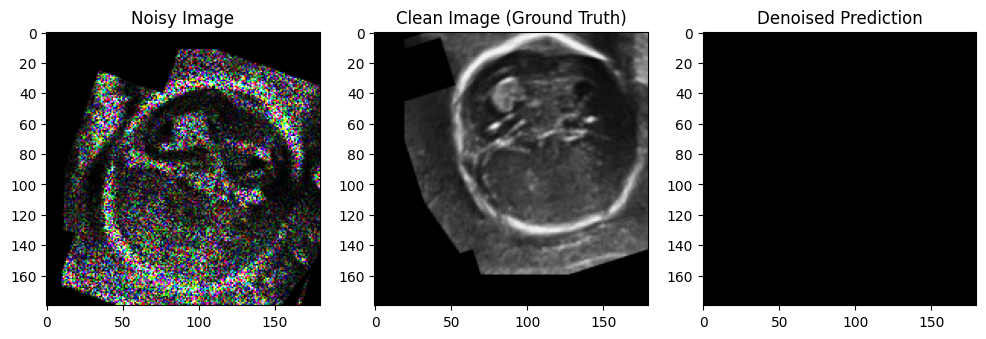

In [15]:
# this code is supposed to plot the denoised prediction, however, as shown in the article - the denoised prediction varies for different imgaes and
# it changes frequently... so it is commented out.
'''
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val_fold[13].squeeze(), cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 3, 2)
plt.imshow(y_val_fold[13].squeeze(), cmap='gray')
plt.title('Clean Image (Ground Truth)')

plt.subplot(1, 3, 3)
plt.imshow(predictions_gray[11].squeeze(), cmap='gray')
plt.title('Denoised Prediction')
plt.show()
'''

In [ ]:
# Thank you, our team tried our best in replicating the article.